In [1]:
from model import FFNet, tv_model, ResBam
from learning import Learn, Selector, Metrics
from dataset import SKDS, TVDS, CDataset, ImageDatasetStats, AsTensor, Squeeze, DType

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms


In [2]:
import numpy as np

class DummyDataset(CDataset):

    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([.02]),
                       'feature_3': ['c'],
                       'feature_4': ['b','a'],
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([.01]),
                       'feature_3': ['a','b','d'],
                       'feature_4': ['d'],
                       'feature_5': np.asarray([1.2])}}
        
        print(boom)
        return datadic
    
class DummyTransform():
    def __call__(self, arr):
        return np.add(arr, 10)
    
class DummyTransformTwo():
    def __call__(self, arr):
        return np.add(arr, 100)
    
ds_params = {'train_params': {'features': ['feature_1','feature_5'],
                              'embeds': ['feature_3','feature_4'],
                              'targets': ['feature_2'],
                              'embed_lookup': {'a': 1, 'b': 2, 'c': 3, 'd': 4},
                              'transform': [DummyTransform(), DummyTransformTwo()],
                              'target_transform': [],
                              'boom': 'bang'}}
    
d = DummyDataset(**ds_params['train_params'])
d[2]

bang
CDataset created...


(array([110.03, 111.2 ]), [array([1, 2, 4]), array([4])], array([0.01]))

In [3]:
ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'make': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

CDataset created...
SKDS make_regression created...


(array([ 2.1619952 , -0.6161172 , -0.49439624, -0.45259795, -2.093188  ],
       dtype=float32),
 [],
 array([93.329475], dtype=float32))

In [4]:
ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'make': 'make_classification',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 10,
                                            'n_informative': 8,
                                            'n_clusters_per_class': 2,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]

CDataset created...
SKDS make_classification created...


(array([ 1.7754136 ,  2.5180297 ,  0.70816183,  3.6728504 ,  0.0369401 ,
        -1.6337373 , -2.5112936 , -0.4763326 ,  2.2652729 , -1.6029338 ],
       dtype=float32),
 [],
 array([2]))

In [5]:
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

CDataset created...
TVDS created...


(<PIL.Image.Image image mode=L size=224x224 at 0x7F56DD1135D0>, [], 0)

In [6]:
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

CDataset created...
TVDS created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


CDataset created...
SKDS make_regression created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.040646
epoch: 0, lr: 0.01
train loss: 637576.4166666666, val loss: 604674.2375
sklearn train metric: 0, sklearn validation metric: 0
test loss: 14186.9330078125
learning time: 0:00:06.523192
sklearn test metric: 
0 



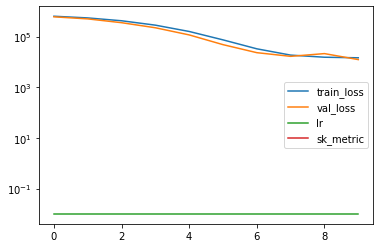

In [7]:
model_params = {'D_in': 256, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': []}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=10)

CDataset created...
SKDS make_classification created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:00.749839
epoch: 0, lr: 0.01
train loss: 1.4209319949150085, val loss: 1.3930737755515359
sklearn train metric: 0.498713205521555, sklearn validation metric: 0.5139161666234284
test loss: 1.1131537773392417
learning time: 0:00:07.456014
sklearn test metric: 
0.8843069508601258 



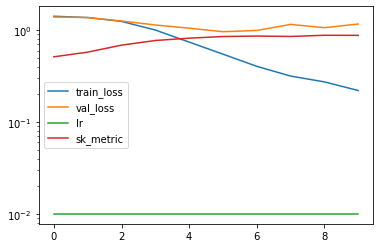

In [8]:
model_params = {'D_in': 256, 
                'H': 192, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': 'X',
                              'targets': 'y',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'make': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=128, epochs=10, squeeze_y=True)

Files already downloaded and verified
CDataset created...
TVDS created...
Files already downloaded and verified
CDataset created...
TVDS created...
TorchVision model resnet18 loaded...
learning time: 0:00:12.486336
epoch: 0, lr: 0.01
train loss: 2.313428858280182, val loss: 2.053193457664982
sklearn train metric: 0.6371713570576077, sklearn validation metric: 0.7161403203728263
learning time: 0:00:24.485573
epoch: 1, lr: 0.01
train loss: 2.0344421076774597, val loss: 2.0143394970124766
sklearn train metric: 0.7182047560793171, sklearn validation metric: 0.7519475383244838
learning time: 0:00:36.448937
epoch: 2, lr: 0.01
train loss: 1.9542736983299256, val loss: 1.9589722060388135
sklearn train metric: 0.7515981889120228, sklearn validation metric: 0.7631740024584303
learning time: 0:00:48.555019
epoch: 3, lr: 0.01
train loss: 1.881962284564972, val loss: 1.8214989919816293
sklearn train metric: 0.7738368318034401, sklearn validation metric: 0.8027296253833164
learning time: 0:01:00.787

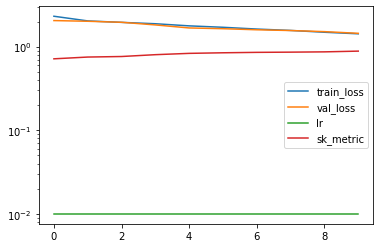

In [9]:
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(224),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(224),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=16, epochs=10)

CDataset created...
TVDS created...
CDataset created...
TVDS created...
CModel loaded...
ResBam model loaded...
learning time: 0:00:25.835735
epoch: 0, lr: 0.005
train loss: 1.9804944581985473, val loss: 1.8744419890065347
sklearn train metric: 0.7444558775570708, sklearn validation metric: 0.7757691061245998
learning time: 0:00:51.493331
epoch: 1, lr: 0.005
train loss: 1.7980906534194947, val loss: 1.7747476139376241
sklearn train metric: 0.7987981284346064, sklearn validation metric: 0.8055768626777564
learning time: 0:01:16.836403
epoch: 2, lr: 0.005
train loss: 1.695070725440979, val loss: 1.7503228418288692
sklearn train metric: 0.8277039916657886, sklearn validation metric: 0.8141717587428049
learning time: 0:01:42.395792
epoch: 3, lr: 0.005
train loss: 1.6410383672714233, val loss: 1.635841715720392
sklearn train metric: 0.8377261839859844, sklearn validation metric: 0.8357008095632139
learning time: 0:02:07.908944
epoch: 4, lr: 0.005
train loss: 1.5647441282272339, val loss: 1.

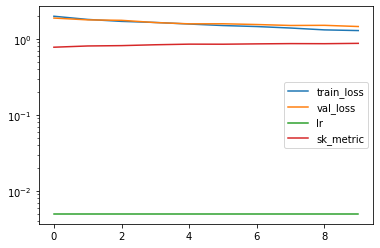

In [10]:
model_params = {'n_classes': 10,
                'residual': True,
                'in_channels': 3,
                'groups': 4,
                'bam': True,
                'dropout': [.1,.2,.3,.2,.1],
                #'act': None
               }


ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize(.13,.29)]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(.13,.29)]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.005}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          ResBam, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=32, epochs=10)

CDataset created...
TVDS created...
CDataset created...
TVDS created...
TorchVision model resnext50_32x4d loaded...
learning time: 0:01:02.174489
epoch: 0, lr: 0.01
train loss: 2.565103487968445, val loss: 2.106171827162466
sklearn train metric: 0.6012227877046712, sklearn validation metric: 0.6872157236394809
learning time: 0:02:03.225138
epoch: 1, lr: 0.01
train loss: 2.08062796497345, val loss: 2.064007630271296
sklearn train metric: 0.6940804948368049, sklearn validation metric: 0.7251707296638656
learning time: 0:03:05.710793
epoch: 2, lr: 0.01
train loss: 2.005425669670105, val loss: 1.9763669890742148
sklearn train metric: 0.7274705091045615, sklearn validation metric: 0.7478963510097674
learning time: 0:04:08.000352
epoch: 3, lr: 0.01
train loss: 1.9612777199745177, val loss: 1.9249129910622873
sklearn train metric: 0.7429658128507584, sklearn validation metric: 0.7722083476190558
learning time: 0:05:09.650902
epoch: 4, lr: 0.01
train loss: 1.8640017595291138, val loss: 1.80128

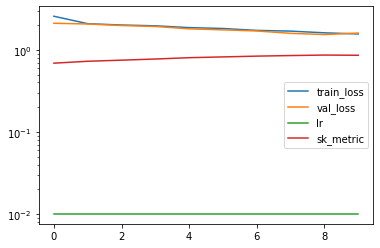

In [2]:
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=16, epochs=10)